#### Install pacman and load required package

In [1]:
install.packages('pacman')
pacman::p_load(frenchdata,purrr,tidyr,dplyr,tidyquant,broom,gtools,ggplot2,kableExtra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘assertthat’



frenchdata installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘globals’, ‘later’, ‘listenv’, ‘parallelly’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘furrr’, ‘htmlwidgets’, ‘crosstalk’, ‘promises’, ‘Rcpp’, ‘warp’, ‘BH’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘RcppRoll’, ‘future’, ‘quadprog’, ‘zoo’, ‘recipes’, ‘rsample’, ‘plotly’, ‘padr’, ‘slider’, ‘anytime’, ‘forecast’, ‘tsfeatures’, ‘PerformanceAnalytics’, ‘quantmod’, ‘lazyeval’, ‘Quandl’, ‘riingo’, ‘alphavantager’, ‘timetk’, ‘timeDate’, ‘TTR’, ‘xts’



tidyquant installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspe

create ETF list

In [2]:
ETFs = c("IVV", "VTI", "VOO", "QQQ", "VEA", "IEFA", "AGG", "VWO",
         "EFA","IEMG","VTV", "IJH", "IWF","BND", "IJR", "IWM", "VUG",
         "GLD", "IWD", "VIG", "VNQ", "USMV", "LQD", "VO", "VYM", "EEM",
         "VB", "VCSH", "XLF", "VCIT", "VEU", "XLK", "ITOT", "IVW", "BNDX",
         "VGT", "DIA", "BSV", "SHV", "IWB", "IWR", "TIP", "SCHF", "MBB", "SDY",
         "MDY", "SCHX", "IEF", "HYG", "DVY", "XLV", "SHY", "IXUS", "TLT", "IVE",
         "PFF", "IAU", "VXUS", "RSP", "SCHB", "VV", "GOVT", "EMB", "MUB", "QUAL",
         "XLY", "VBR", "EWJ", "XLP", "VGK", "SPLV", "MINT", "BIV", "IGSB", "EFAV",
         "VT", "GDX", "XLU", "IWS", "XLI", "SCHD", "IWP", "ACWI", "VMBS", "XLE", "JNK",
         "VOE", "FLOT", "IWV", "JPST", "SCZ", "IEI", "IWN", "DGRO", "VBK", "IGIB", "IWO")


Set start date and end date

In [3]:
start = "2012-01-01" ; end = "2019-01-01"

To see the list of fama french models, execute the following code:

In [4]:
frenchdata::get_french_data_list()$files_list %>% head

name,file_url,details_url
<chr>,<chr>,<chr>
Fama/French 3 Factors,ftp/F-F_Research_Data_Factors_CSV.zip,Data_Library/f-f_factors.html
Fama/French 3 Factors [Weekly],ftp/F-F_Research_Data_Factors_weekly_CSV.zip,Data_Library/f-f_factors.html
Fama/French 3 Factors [Daily],ftp/F-F_Research_Data_Factors_daily_CSV.zip,Data_Library/f-f_factors.html
Fama/French 5 Factors (2x3),ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip,Data_Library/f-f_5_factors_2x3.html
Fama/French 5 Factors (2x3) [Daily],ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip,Data_Library/f-f_5_factors_2x3.html
Portfolios Formed on Size,ftp/Portfolios_Formed_on_ME_CSV.zip,Data_Library/det_port_form_sz.html


1. Download fama french 3 factors model (monthly)
2. Preprocess "date" columns data
3. Divide 100 if the data type is numeric
4. Rename mkt-rf column
5. Extract data dated from start to end

In [5]:
ff3_data = frenchdata::download_french_data("Fama/French 3 Factors")$subsets$data[[1]] %>%
  mutate(date = rollback(ymd(parse_date_time(date, "%Y%m") + months(1)))) %>%
  mutate_if(is.numeric, function(x) (x/100)) %>%
  rename(ExR = `Mkt-RF`) %>%
  filter(date >= start & date <= end)

New names:
• `` -> `...1`
New names:
• `` -> `...1`


In [6]:
ff3_data %>% head

date,ExR,SMB,HML,RF
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2012-01-31,0.0505,0.0204,-0.0097,0e+00
2012-02-29,0.0442,-0.0185,0.0043,0e+00
2012-03-31,0.0311,-0.0064,0.0114,0e+00
2012-04-30,-0.0085,-0.0042,-0.0078,0e+00
2012-05-31,-0.0619,0.0007,-0.0107,1e-04
2012-06-30,0.0389,0.0067,0.0062,0e+00


1. Download ETFs price data
2. Convert data into monthly data
3. Calculate log return
4. Reorganize data frame
5. Combine with ff3_data

In [7]:
data = tq_get(
  ETFs,
  from = start,
  to = end
) %>%
  group_by(symbol) %>%
  tq_transmute(
    select = adjusted,
    mutate_fun = to.monthly,
    indexAt = "lastof"
  ) %>%
  tq_transmute(
    select = adjusted,
    mutate_fun = periodReturn,
    type = "log"
  ) %>%
  pivot_wider(
    names_from = symbol,
    values_from = monthly.returns
  ) %>%
  slice(-1) %>%
  right_join(ff3_data,., by="date")


In [8]:
data %>% head

date,ExR,SMB,HML,RF,IVV,VTI,VOO,QQQ,VEA,⋯,FLOT,IWV,JPST,SCZ,IEI,IWN,DGRO,VBK,IGIB,IWO
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012-02-29,0.0442,-0.0185,0.0043,0e+00,0.041256091,0.041319584,0.041927747,0.062129966,0.047685594,⋯,0.0091378588,0.040853275,NA,0.051267075,-0.006246850,0.01445588,NA,0.037989240,0.012094769,0.03269401
2012-03-31,0.0311,-0.0064,0.0114,0e+00,0.032432324,0.030215997,0.032493099,0.049295090,0.003266772,⋯,0.0022781565,0.029413523,NA,0.007754774,-0.005845611,0.03053492,NA,0.022280308,-0.001945263,0.02089371
2012-04-30,-0.0085,-0.0042,-0.0078,0e+00,-0.006607714,-0.006386890,-0.006390167,-0.011763817,-0.024090283,⋯,-0.0040247771,-0.005538789,NA,-0.007754774,0.011856115,-0.01532892,NA,-0.009940088,0.006766594,-0.01777088
2012-05-31,-0.0619,0.0007,-0.0107,1e-04,-0.061975356,-0.064278295,-0.061915340,-0.073002472,-0.118422875,⋯,0.0001813985,-0.062656921,NA,-0.121620390,0.008393618,-0.06274036,NA,-0.074742482,0.001072941,-0.07338585
2012-06-30,0.0389,0.0067,0.0062,0e+00,0.041216276,0.039654405,0.040525947,0.035574018,0.067477918,⋯,0.0043908880,0.037399001,NA,0.040622738,-0.001981549,0.04871227,NA,0.047424364,0.004786477,0.05150558
2012-07-31,0.0079,-0.0274,-0.0002,0e+00,0.012354425,0.008713799,0.011970364,0.009925598,0.002530928,⋯,0.0036572637,0.008792927,NA,-0.011969598,0.006948377,-0.01258052,NA,-0.013460068,0.014767235,-0.01864884


1. Create tibble table using ETFs, and linear regression model using map
2. Extract information of linear regression using unnest()
3. Select necessary columns
4. Reorganize data frame
5. Create a new column and fill it with values based on certain conditions

In [10]:
plot_df = tibble(
  ETFs = ETFs,
  model = map(ETFs, ~lm(get(.x) ~ ExR + SMB + HML + RF, data = data) %>%
                tidy)
) %>%
  unnest(model) %>%
  select(ETFs,term,estimate) %>%
  mutate(estimate = round(estimate,digits=4)) %>%
  pivot_wider(
    names_from = term,
    values_from = estimate
  ) %>%
  select(ETFs, SMB,HML) %>%
  mutate(
    class = case_when(
      SMB > 0 & HML > 0 ~ "Smallcap + Value",
      SMB > 0 & HML < 0 ~ "Smallcap + Growth" ,
      SMB < 0 & HML > 0 ~ "Largecap + Value",
      SMB < 0 & HML < 0 ~ "Largecap + Growth",
      TRUE ~ "else"
    )
  )

In [11]:
plot_df %>% head

ETFs,SMB,HML,class
<chr>,<dbl>,<dbl>,<chr>
IVV,-0.1215,-0.0193,Largecap + Growth
VTI,-0.0002,-0.0145,Largecap + Growth
VOO,-0.1217,-0.0201,Largecap + Growth
QQQ,-0.2336,-0.5143,Largecap + Growth
VEA,-0.2010,-0.0645,Largecap + Growth
IEFA,-0.1808,-0.1326,Largecap + Growth


Visualize plot_df using ggplot (Morningstar style box)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


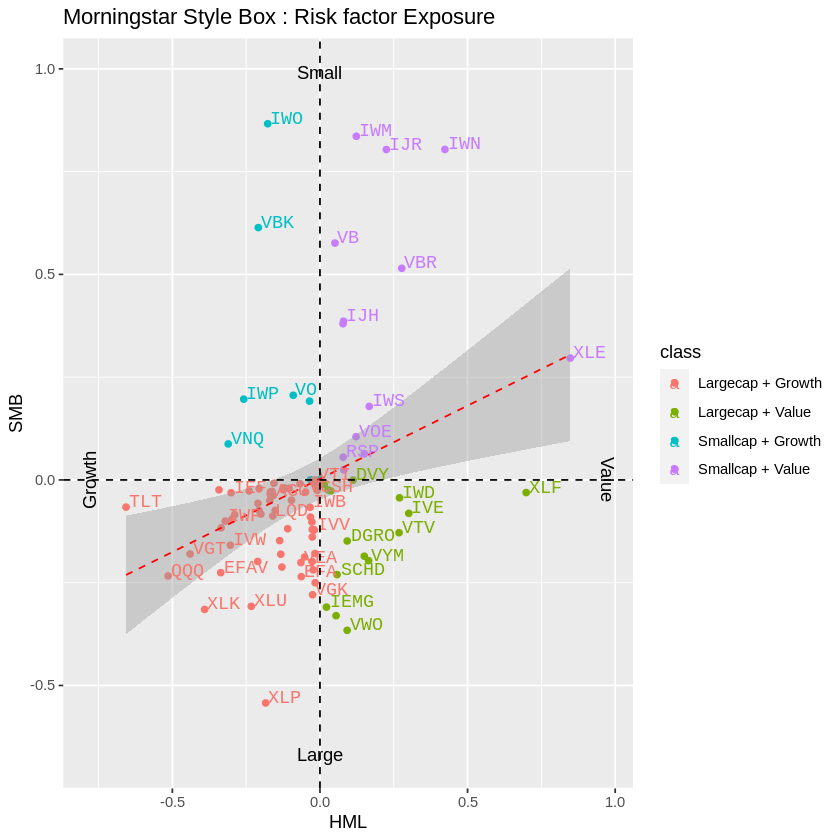

In [12]:
ggplot(plot_df) +
  aes(x = HML, y = SMB, color = class) +
  geom_point() +
  geom_smooth(method = "lm", se = TRUE,
              color = "red", aes(group = 1),,
              size = 0.5,
              linetype = "dashed") +
  geom_text(aes(label=ETFs),
            family = "nanumgothic", vjust = 0, hjust = -0.08,
            check_overlap = T)  +
  geom_vline(aes(xintercept = 0), color = "black", linetype = "dashed") +
  geom_hline(aes(yintercept = 0), color = "black", linetype = "dashed") +
  ggtitle("Morningstar Style Box : Risk factor Exposure") +
  annotate("text", x = 0, y = min(plot_df$SMB)-0.125, label = "Large", angle = 0, hjust = 0.5) +
  annotate("text", x = 0, y = max(plot_df$SMB)+0.125, label = "Small", angle = 0,hjust = 0.5) +
  annotate("text", x = max(plot_df$HML)+0.125, y = 0, label = "Value", angle = 270, hjust = 0.5) +
  annotate("text", x = min(plot_df$HML)-0.125, y = 0, label = "Growth", angle = 90,hjust = 0.5)

If you want to create a table to view the validity of a p-value, see the following code

In [13]:
factor_p_table = tibble(
  ETFs = ETFs,
  model = map(ETFs, ~ lm(get(.x) ~ ExR + SMB + HML + RF, data = data) %>%
                tidy %>%
                mutate(pvalue = stars.pval(p.value)))
) %>%
  unnest(model) %>%
  mutate(value = paste0(round(estimate, digits=3), " ", pvalue)) %>%
  select(ETFs,term,value) %>%
  pivot_wider(
    names_from = term,
    values_from = value
  )

factor_p_table$ETFs = cell_spec(factor_p_table$ETFs, bold = T)

factor_p_table %>%
  kable("html", escape = F) %>%
  kable_styling() %>%
  add_footnote(c(paste0("Date from: ",data$date[1]," to: ",data$date[nrow(data)]),
                 "p*** < 0.001 | p** < 0.01 | p* < 0.05 | p. < 0.1"))

<table class="table" style="margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:left;"> ETFs </th>
   <th style="text-align:left;"> (Intercept) </th>
   <th style="text-align:left;"> ExR </th>
   <th style="text-align:left;"> SMB </th>
   <th style="text-align:left;"> HML </th>
   <th style="text-align:left;"> RF </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> <span style=" font-weight: bold;    ">IVV</span> </td>
   <td style="text-align:left;"> 0 </td>
   <td style="text-align:left;"> 0.981 *** </td>
   <td style="text-align:left;"> -0.122 *** </td>
   <td style="text-align:left;"> -0.019 </td>
   <td style="text-align:left;"> 0.536 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> <span style=" font-weight: bold;    ">VTI</span> </td>
   <td style="text-align:left;"> -0.001 . </td>
   <td style="text-align:left;"> 0.991 *** </td>
   <td style="text-align:left;"> 0 </td>
   <td style="text-align:left;"> -0.015 </td>
   <td sty

The result will be created as below:

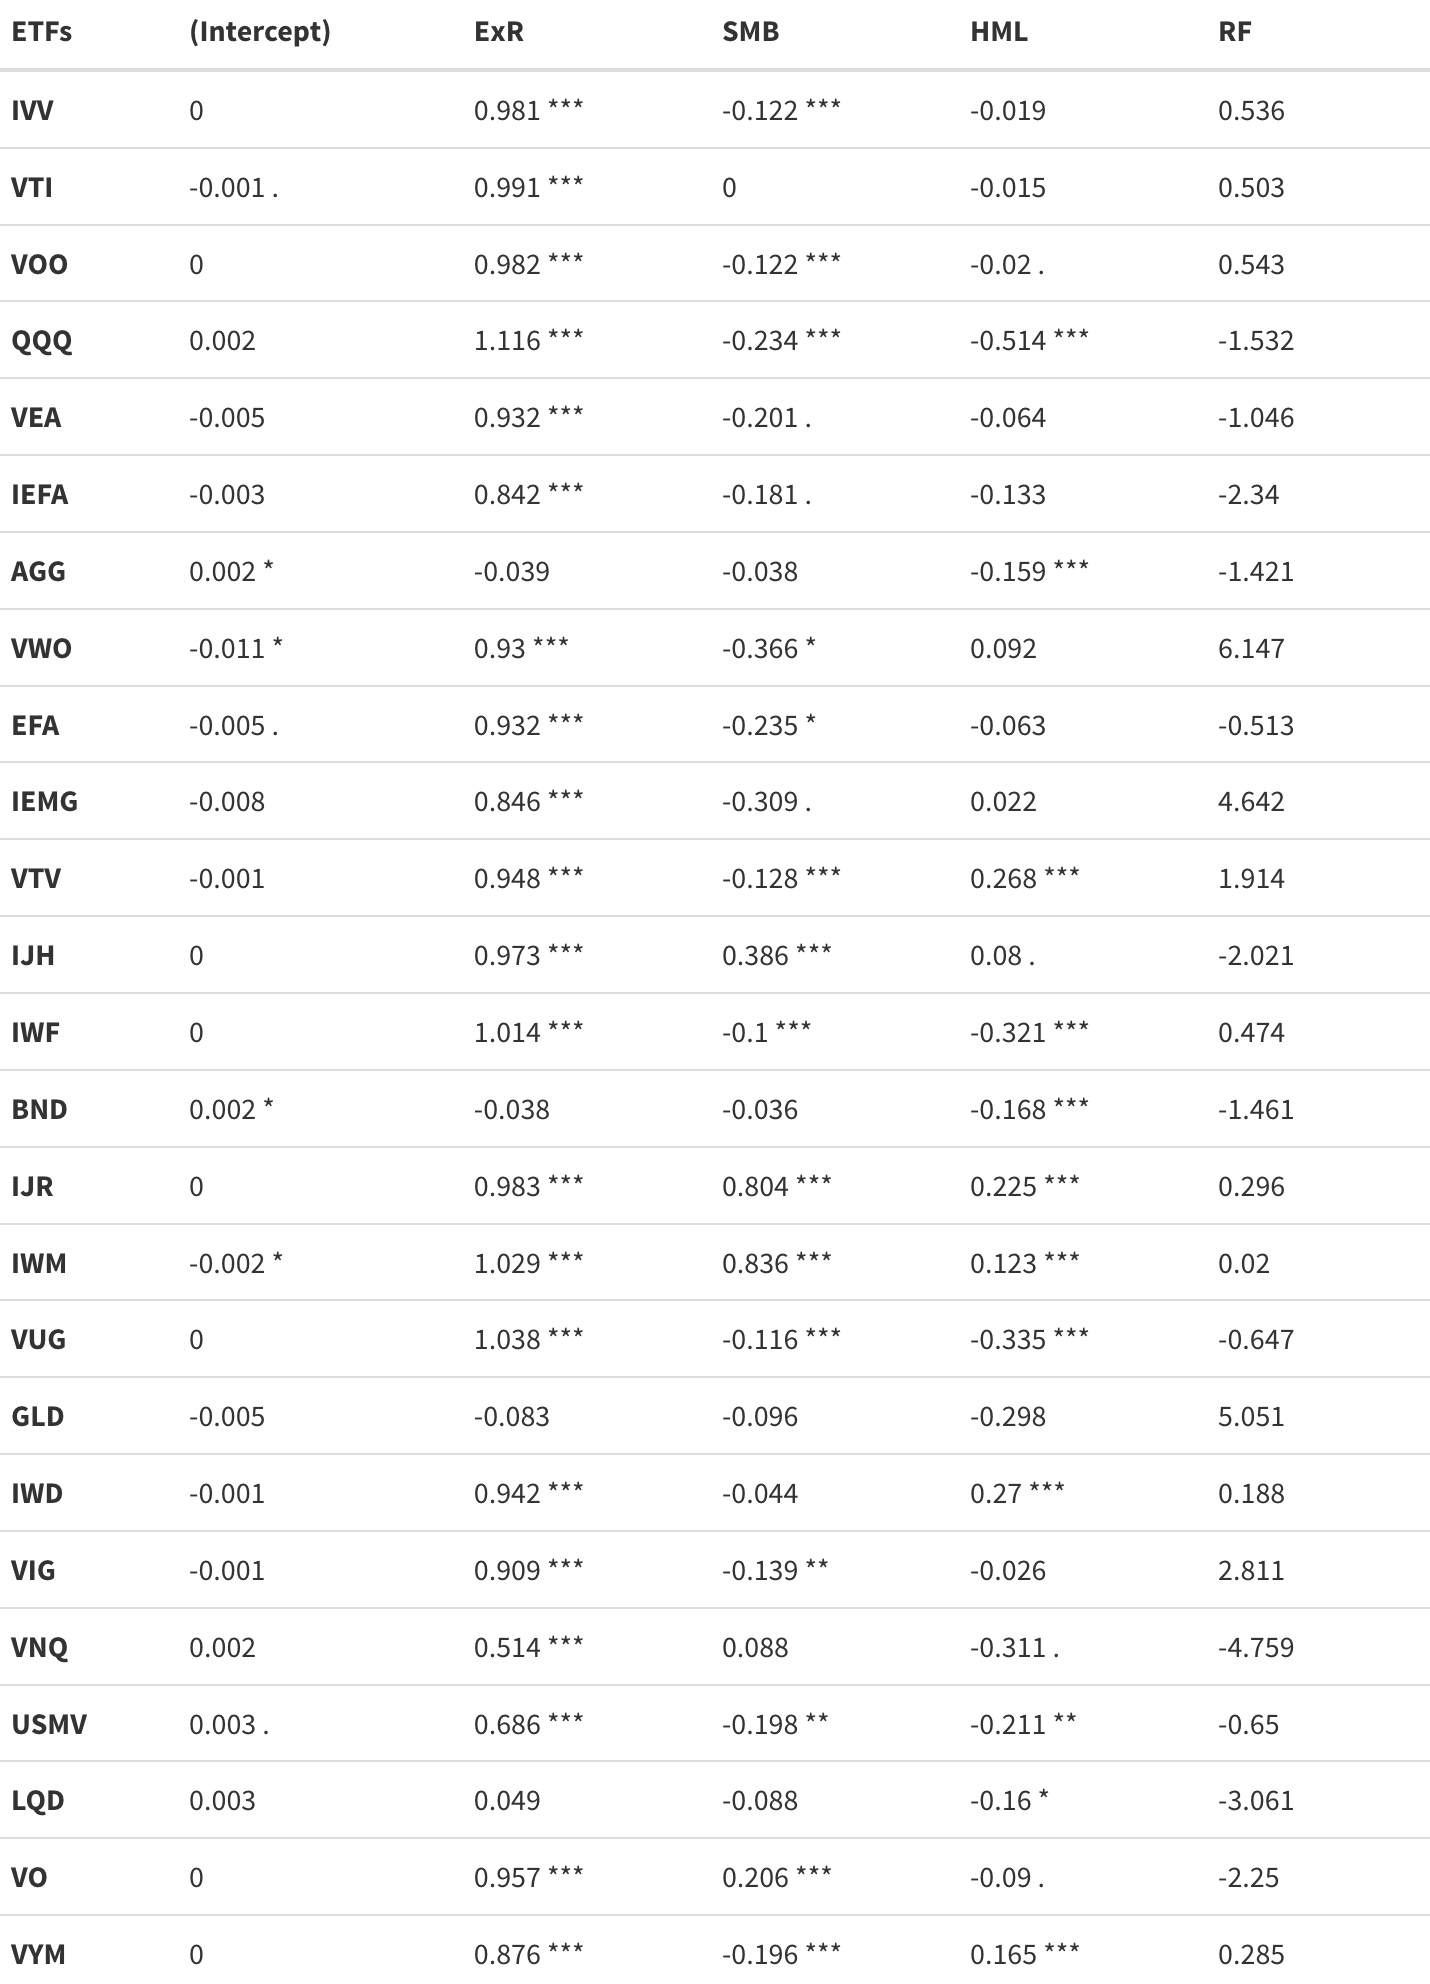